In [2]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from datetime import datetime
import json
import joblib

# Suppress TensorFlow INFO and WARNING messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Enable memory growth if using GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Data Loading and Preprocessing

In [3]:
# Load the data
df = pd.read_csv('../data/raw/Train.csv')

# Convert Time to datetime with explicit format (day first)
df['Time'] = pd.to_datetime(df['Time'], format='%d-%m-%Y %H:%M')

# Select features (excluding Location and index column)
feature_columns = ['Temp_2m', 'RelHum_2m', 'DP_2m', 'WS_10m', 'WS_100m', 
                   'WD_10m', 'WD_100m', 'WG_10m', 'Power']

# Create feature matrix
data = df[feature_columns].values

# Determine split indices based on the original data length
total_samples = data.shape[0]
train_end = int(0.7 * total_samples)
val_end = train_end + int(0.15 * total_samples)

# Split the data
train_data = data[:train_end]
val_data = data[train_end:val_end]
test_data = data[val_end:]

# Initialize scaler
scaler = StandardScaler()

# Fit the scaler on the training data (excluding the target column)
scaled_train_features = scaler.fit_transform(train_data[:, :-1])

# Transform validation and test data
scaled_val_features = scaler.transform(val_data[:, :-1])
scaled_test_features = scaler.transform(test_data[:, :-1])

# Combine scaled features with the target variable
scaled_train_data = np.column_stack((scaled_train_features, train_data[:, -1]))
scaled_val_data = np.column_stack((scaled_val_features, val_data[:, -1]))
scaled_test_data = np.column_stack((scaled_test_features, test_data[:, -1]))

print("Data shapes after scaling and splitting:")
print(f"Training data shape: {scaled_train_data.shape}")
print(f"Validation data shape: {scaled_val_data.shape}")
print(f"Test data shape: {scaled_test_data.shape}")

Data shapes after scaling and splitting:
Training data shape: (98112, 9)
Validation data shape: (21024, 9)
Test data shape: (21024, 9)


## Creating Sliding Windows for Time Series Data

In [4]:
def create_windows(data, window_size=12, target_col=-1):
    """
    Create sliding windows from time series data.
    """
    X, y = [], []
    for i in range(len(data) - window_size):
        window = data[i:(i + window_size)]
        target = data[i + window_size, target_col]
        X.append(window)
        y.append(target)
    return np.array(X), np.array(y)

# Create windows for training, validation, and test data
X_train, y_train = create_windows(scaled_train_data, window_size=12)
X_val, y_val = create_windows(scaled_val_data, window_size=12)
X_test, y_test = create_windows(scaled_test_data, window_size=12)

print("\nWindowed dataset shapes:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}")
print(f"y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_test:  {y_test.shape}")


Windowed dataset shapes:
X_train: (98100, 12, 9)
y_train: (98100,)
X_val:   (21012, 12, 9)
y_val:   (21012,)
X_test:  (21012, 12, 9)
y_test:  (21012,)


## Defining Model and Genetic Optimizer

In [7]:
# Define parameters for the genetic algorithm
population_size = 50
generations = 100
mutation_rate = 0.01
elite_frac = 0.1
patience = 10 

# Define model creation function
def create_ga_model():
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    # Compile the model to prevent automatic compilation during prediction
    model.compile(optimizer='sgd', loss='mse')
    return model

# Fitness function
def evaluate_population(models):
    scores = []
    for model in models:
        predictions = model.predict(X_val, verbose=0).squeeze()
        mse = mean_squared_error(y_val, predictions)
        scores.append(-mse)  # Negative MSE since we want to minimize it
    return np.array(scores)

# Initialize population 
def initialize_population(population_size):
    return [create_ga_model() for _ in range(population_size)]

# Selection 
def select_mating_pool(population, scores, elite_frac):
    elite_size = int(elite_frac * len(scores))
    elite_indices = np.argsort(scores)[-elite_size:]
    return [population[i] for i in elite_indices], scores[elite_indices]

# Crossover 
def crossover(parent1, parent2):
    child = create_ga_model()
    for i, layer in enumerate(child.layers):
        if hasattr(layer, 'weights'):
            weights1 = parent1.layers[i].get_weights()
            weights2 = parent2.layers[i].get_weights()
            child_weights = [0.5 * (w1 + w2) for w1, w2 in zip(weights1, weights2)]
            layer.set_weights(child_weights)
    return child

# Mutation 
def mutate(model, mutation_rate):
    for layer in model.layers:
        if hasattr(layer, 'weights'):
            weights = layer.get_weights()
            new_weights = [w + mutation_rate * np.random.randn(*w.shape) for w in weights]
            layer.set_weights(new_weights)

# Genetic algorithm main loop with early stopping
def genetic_algorithm(patience=10):
    # Initialize history lists
    best_mse_list = []
    mean_mse_list = []
    std_mse_list = []
    
    # Initialize variables
    population = initialize_population(population_size)
    best_score = None
    best_generation = 0
    no_improvement_count = 0
    for generation in range(generations):
        scores = evaluate_population(population)
        best_mse = -np.max(scores)
        mean_mse = -np.mean(scores)
        std_mse = np.std(scores)
        
        # Append to history lists
        best_mse_list.append(best_mse)
        mean_mse_list.append(mean_mse)
        std_mse_list.append(std_mse)
        
        # Single output line per generation with relevant information
        print(f"Generation {generation + 1} - Best MSE: {best_mse:.4f}, Mean MSE: {mean_mse:.4f}, Std MSE: {std_mse:.4f}")
        
        # Early stopping logic
        if best_score is None or best_mse < best_score:
            best_score = best_mse
            best_generation = generation
            no_improvement_count = 0
            # Save the best population
            best_population = population.copy()
            best_elite_scores = scores.copy()
        else:
            no_improvement_count += 1
            if no_improvement_count >= patience:
                print(f"No improvement in best MSE for {patience} generations. Early stopping.")
                break
        
        # Select mating pool
        elite, elite_scores = select_mating_pool(population, scores, elite_frac)
        new_population = elite.copy()
        
        # Create offspring
        while len(new_population) < population_size:
            parent1, parent2 = np.random.choice(elite, 2)
            child = crossover(parent1, parent2)
            mutate(child, mutation_rate)
            new_population.append(child)
        
        # Update population
        population = new_population
    else:
        # If loop wasn't broken by early stopping, save the last population
        best_population = population.copy()
        best_elite_scores = scores.copy()
        best_generation = generations - 1
    
    print(f"Best MSE achieved at generation {best_generation + 1}: {best_score:.4f}")
    
    # Prepare history dictionary
    ga_history = {
        'best_mse': best_mse_list,
        'mean_mse': mean_mse_list,
        'std_mse': std_mse_list
    }
    
    return best_population, best_elite_scores, ga_history, best_generation, best_score


## Model Training

In [8]:
# Run the genetic algorithm with early stopping
final_population, final_scores, ga_history, best_generation, best_score = genetic_algorithm(patience=patience)

# Identify the best model from the final population
best_model_index = np.argmax(final_scores)
best_model = final_population[best_model_index]

Generation 1 - Best MSE: 0.0379, Mean MSE: 0.1559, Std MSE: 0.0811
Generation 2 - Best MSE: 0.0368, Mean MSE: 0.0684, Std MSE: 0.0098
Generation 3 - Best MSE: 0.0358, Mean MSE: 0.0586, Std MSE: 0.0115
Generation 4 - Best MSE: 0.0355, Mean MSE: 0.0367, Std MSE: 0.0008
Generation 5 - Best MSE: 0.0347, Mean MSE: 0.0358, Std MSE: 0.0005
Generation 6 - Best MSE: 0.0343, Mean MSE: 0.0352, Std MSE: 0.0005
Generation 7 - Best MSE: 0.0338, Mean MSE: 0.0347, Std MSE: 0.0004
Generation 8 - Best MSE: 0.0335, Mean MSE: 0.0344, Std MSE: 0.0005
Generation 9 - Best MSE: 0.0331, Mean MSE: 0.0338, Std MSE: 0.0004
Generation 10 - Best MSE: 0.0327, Mean MSE: 0.0334, Std MSE: 0.0003
Generation 11 - Best MSE: 0.0323, Mean MSE: 0.0331, Std MSE: 0.0004
Generation 12 - Best MSE: 0.0318, Mean MSE: 0.0326, Std MSE: 0.0004
Generation 13 - Best MSE: 0.0313, Mean MSE: 0.0320, Std MSE: 0.0004
Generation 14 - Best MSE: 0.0310, Mean MSE: 0.0317, Std MSE: 0.0004
Generation 15 - Best MSE: 0.0308, Mean MSE: 0.0314, Std M

## Evaluating the Model

In [9]:
# Create a unique directory for the results based on the current timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results_dir = f'../results/ga_run_{timestamp}'
os.makedirs(results_dir, exist_ok=True)

# Evaluate the best model on the test set
test_predictions = best_model.predict(X_test, verbose=0).squeeze()
r2_test = r2_score(y_test, test_predictions)
mse_test = mean_squared_error(y_test, test_predictions)
mae_test = mean_absolute_error(y_test, test_predictions)
print(f"\nTest R² score: {r2_test:.4f}")
print(f"Test MSE: {mse_test:.6f}")
print(f"Test MAE: {mae_test:.6f}")

# Save evaluation metrics
evaluation_metrics = {
    'test_r2_score': float(r2_test),
    'test_mse': float(mse_test),
    'test_mae': float(mae_test),
    'best_mse': float(best_score),
    'best_generation': int(best_generation + 1),
}

evaluation_metrics_path = os.path.join(results_dir, 'evaluation_metrics.json')
with open(evaluation_metrics_path, 'w') as f:
    json.dump(evaluation_metrics, f, indent=4)


Test R² score: 0.7598
Test MSE: 0.012933
Test MAE: 0.084479


## Visualizations

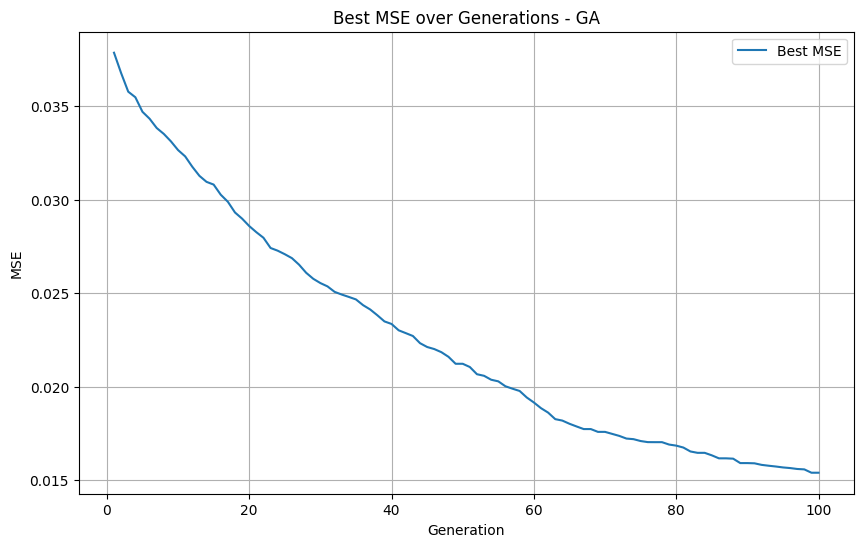

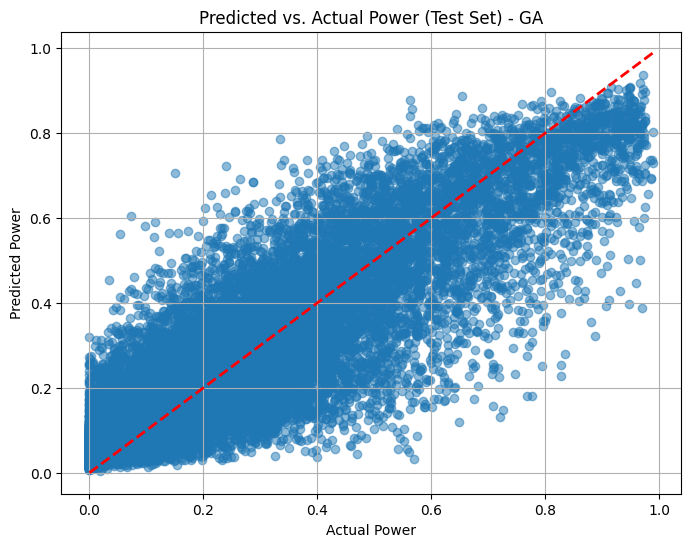

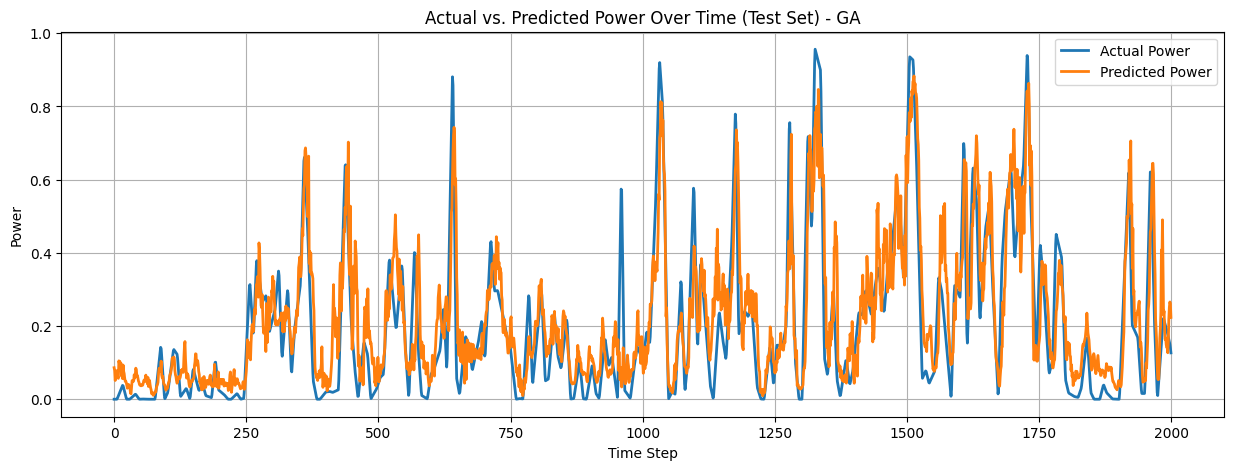

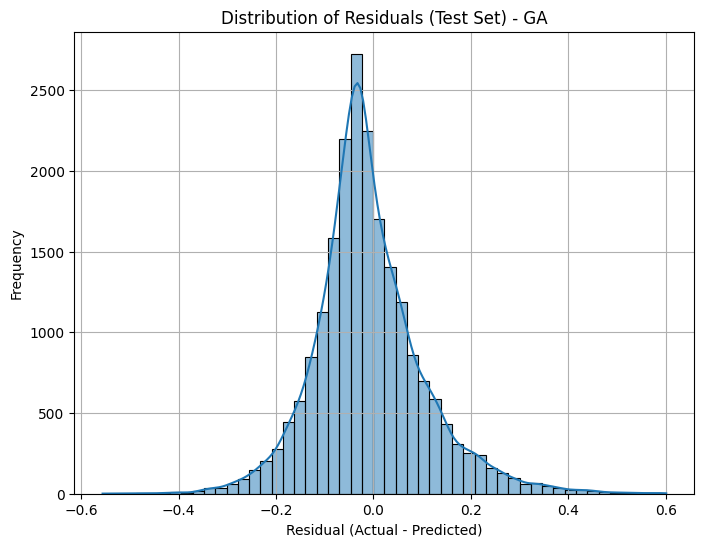

In [10]:
# Plot GA Training History

# Plot Best MSE over Generations
plt.figure(figsize=(10,6))
plt.plot(range(1, len(ga_history['best_mse'])+1), ga_history['best_mse'], label='Best MSE')
plt.xlabel('Generation')
plt.ylabel('MSE')
plt.title('Best MSE over Generations - GA')
plt.grid(True)
plt.legend()
best_mse_plot_path = os.path.join(results_dir, 'best_mse_over_generations_ga.png')
plt.savefig(best_mse_plot_path)
plt.show()

# Visualizations using the Test Set

## Scatter Plot: Predicted vs. Actual Values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, test_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Power')
plt.ylabel('Predicted Power')
plt.title('Predicted vs. Actual Power (Test Set) - GA')
plt.grid(True)
scatter_plot_path = os.path.join(results_dir, 'predicted_vs_actual_scatter_ga.png')
plt.savefig(scatter_plot_path)
plt.show()

## Line Chart: Actual vs. Predicted Values Over Time
# Select a small continuous portion of the data
start_idx = 0  # Adjust as needed
end_idx = start_idx + 2000

plt.figure(figsize=(15, 5))
plt.plot(range(start_idx, end_idx), y_test[start_idx:end_idx], label='Actual Power', linewidth=2)
plt.plot(range(start_idx, end_idx), test_predictions[start_idx:end_idx], label='Predicted Power', linewidth=2)
plt.xlabel('Time Step')
plt.ylabel('Power')
plt.title('Actual vs. Predicted Power Over Time (Test Set) - GA')
plt.legend()
plt.grid(True)
line_chart_path = os.path.join(results_dir, 'actual_vs_predicted_over_time_ga.png')
plt.savefig(line_chart_path)
plt.show()

## Distribution of Residuals
residuals = y_test - test_predictions
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=50)
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals (Test Set) - GA')
plt.grid(True)
residuals_plot_path = os.path.join(results_dir, 'residuals_distribution_ga.png')
plt.savefig(residuals_plot_path)
plt.show()

## Saving the Model and Artifacts

In [11]:
# 1. Save Model Weights and Architecture

## Save the model weights
model_weights_path = os.path.join(results_dir, 'best_model.weights.h5')
best_model.save_weights(model_weights_path)

## Save the model architecture to JSON
model_json = best_model.to_json()
model_architecture_path = os.path.join(results_dir, 'best_model_architecture.json')
with open(model_architecture_path, 'w') as json_file:
    json_file.write(model_json)

# 2. Save Training Parameters

## Save GA training parameters
training_params = {
    'population_size': population_size,
    'generations': generations,
    'mutation_rate': mutation_rate,
    'elite_frac': elite_frac,
    'patience': patience,
    'window_size': 12,
    'n_timesteps': X_train.shape[1],
    'n_features': X_train.shape[2],
    'train_size': X_train.shape[0],
    'validation_size': X_val.shape[0],
    'test_size': X_test.shape[0],
    'random_seed': 42,
}

training_params_path = os.path.join(results_dir, 'training_params.json')
with open(training_params_path, 'w') as f:
    json.dump(training_params, f, indent=4)

# 3. Save Training History

## Save GA training history
training_history_path = os.path.join(results_dir, 'ga_training_history.json')
with open(training_history_path, 'w') as f:
    json.dump(ga_history, f, indent=4)

# 4. Save Scaler Object

## Save the scaler used for data preprocessing
scaler_path = os.path.join(results_dir, 'scaler.pkl')
joblib.dump(scaler, scaler_path)

# 5. Save Model Summary

## Capture the model summary to a text file
model_summary_path = os.path.join(results_dir, 'best_model_summary.txt')
with open(model_summary_path, 'w') as f:
    best_model.summary(print_fn=lambda x: f.write(x + '\n'))

# 6. Notify Completion and Results Directory
print(f"\nAll results have been saved to the directory: {results_dir}")


All results have been saved to the directory: ../results/ga_run_20241111_152148
